# Pesudo Labeling
What is pesudo labeling? In a very simple explanation, we use pretrain model to predict the testing data(without label), then take the high confidence predicted label as **pesudo label**. After that, we can re-train the model with original training dataset and the testing data with **pesudo label**. Although it is a very simple way to increase your training dataset, but we should aware that pesudo labeling might cause serious overfitting. <br />

In this notebook, I use a model train with original flower dataset and use the this model to predict the testing dataset. Then filter out the prediction with accuracy lower than 0.99 and write the testing images with high confidence into tfrec format. Thus we can use these data to retrain our new model. <br />

## Reminder:

By the way, I already tried this method two days ago, and it didn't improve my score. But it is still hard to tell that pesudo labeling will be helpful in this competiton or not, this just my quick trial result.

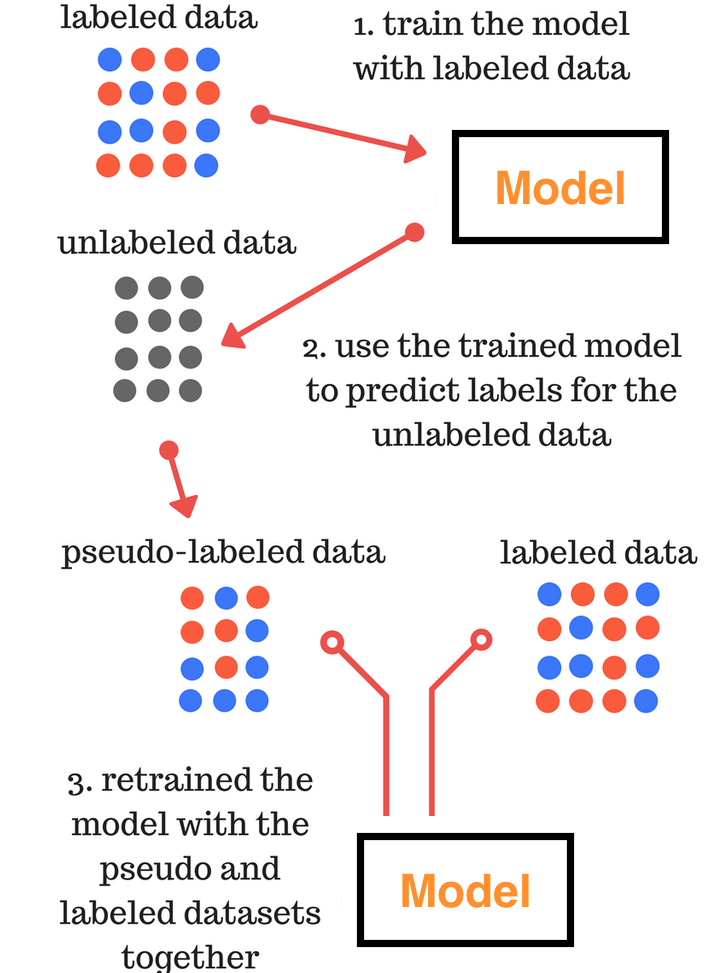

In [ ]:
!pip install -U git+https://github.com/qubvel/efficientnet

In [ ]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']

In [ ]:
import math
import os, re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from math import cos, floor, pi
import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

AUTO = tf.data.experimental.AUTOTUNE
print('Tensorflow version : {}'.format(tf.__version__))

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU : {}'.format(tpu.master()))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Replicas : {}".format(strategy.num_replicas_in_sync))

In [ ]:
main_dir = '../input/flower-ensemble'
pretrain_path = [
    os.path.join(main_dir, 'EFN7_fold1.hdf5'),
]

In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')
GCS_PATH = os.path.join(GCS_DS_PATH, 'tfrecords-jpeg-512x512')

TEST_FNS = tf.io.gfile.glob(os.path.join(GCS_PATH, 'test/*.tfrec'))

NUM_TEST_IMAGES = np.sum([int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in TEST_FNS])


IMG_DIM = (512, 512)
CLASSES_NUM = len(CLASSES)
BATCH_SIZE = 16 * strategy.num_replicas_in_sync


Params = {'weights' : 'noisy-student',
          'input_shape' : (*IMG_DIM, 3),
          'include_top' : False}

In [ ]:
class Dataset:
    
    def __init__(self,
                 filenames,
                 data_len,
                 image_shape,
                 classes,
                 mode,
                 batch_size=BATCH_SIZE,
                 ):
        
        self.filenames = filenames
        self.data_len = data_len
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.classes = classes
        self.mode = mode

        
    def get_dataset(self, order=False, drop_remainder=True):
        
        data_options = tf.data.Options()
        if not order:
            data_options.experimental_deterministic = False
        
        ds = tf.data.TFRecordDataset(self.filenames, num_parallel_reads=AUTO)
        ds = ds.with_options(data_options)
        ds = ds.map(self._read_labeled_tfrecord if self.mode != 'test' else self._read_unlabeled_tfrecord, num_parallel_calls=AUTO)
        ds = ds.batch(self.batch_size, drop_remainder=drop_remainder) 
        ds = ds.prefetch(AUTO)
        
        return ds
    
    def _decoded_image(self, image_data):
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.reshape(image, [*self.image_shape, 3])

        return tf.cast(image, tf.float32) / 255.0
    
    def _read_labeled_tfrecord(self, example):
        Labeled_tfrec_format = {
            "image" : tf.io.FixedLenFeature([], tf.string),
            "class" : tf.io.FixedLenFeature([], tf.int64)
        }
        
        example = tf.io.parse_single_example(example, Labeled_tfrec_format)
        image = self._decoded_image(example['image'])
        label = example['class']
        
        return image, label

    def _read_unlabeled_tfrecord(self, example):
        Unlabeled_tfrec_format = {
            "image" : tf.io.FixedLenFeature([], tf.string),
            "id" : tf.io.FixedLenFeature([], tf.string)
        }
        
        example = tf.io.parse_single_example(example, Unlabeled_tfrec_format)
        image = self._decoded_image(example['image'])
        id_num = example['id']
        return image, id_num

In [ ]:
def build_model(base_model):
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(units=CLASSES_NUM, activation='softmax')(x)
    return tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

In [ ]:
with strategy.scope():
    
    
    base_model = efn.EfficientNetB7(**Params)
    model = build_model(base_model)
    print('Load pretrain weights')
    model.load_weights(pretrain_path[0])


In [ ]:
test_ds = Dataset(filenames=TEST_FNS,
                   data_len=NUM_TEST_IMAGES,
                   image_shape=IMG_DIM,
                   classes=CLASSES_NUM,
                   mode='test',
                   batch_size=BATCH_SIZE,
                   ).get_dataset(order=True, drop_remainder=False)

test_image_ds = test_ds.map(lambda image, id_num : image)

In [ ]:
prediction = model.predict(test_image_ds)
prediction_max = np.max(prediction, axis=1)
prediction = np.argmax(prediction, axis=-1)

test_id_ds = test_ds.map(lambda image, id_num : id_num)
test_ids = next(iter(test_id_ds.unbatch().batch(NUM_TEST_IMAGES))).numpy().astype('U')

In [ ]:
!mkdir /kaggle/working/Flower_PesudoLabeling_tfrec

In [ ]:
PesudoLabeling_ds = Dataset(filenames=TEST_FNS,
                            data_len=NUM_TEST_IMAGES,
                            image_shape=IMG_DIM,
                            classes=CLASSES_NUM,
                            mode='test',
                            batch_size=1,
                            ).get_dataset(order=True, drop_remainder=False)

PesudoLabeling_image_ds = PesudoLabeling_ds.map(lambda image, id_num : image)

best_record_file_num = 320
target_path = '/kaggle/working/Flower_PesudoLabeling_tfrec/'
record_file_num=0
num=0
PL_num = 0
record_filename = ("PL_%.3d.tfrec" % record_file_num)

writer = tf.io.TFRecordWriter(target_path + record_filename)

In [ ]:
for idx, test_image in enumerate(PesudoLabeling_image_ds):
    pm = prediction_max[idx]
    label = prediction[idx]
    
    if pm >= 0.99:
        PL_num += 1
        num += 1
        if num > best_record_file_num:
            num = 1
            record_file_num += 1
            record_filename = ("PL_%.3d.tfrec" % record_file_num)
            writer = tf.io.TFRecordWriter(target_path + record_filename)
        test_image = tf.squeeze(test_image, axis=0)
        test_image = tf.cast(test_image * 255.0, tf.uint8)
        test_image = tf.image.encode_jpeg(test_image, optimize_size=True, chroma_downsampling=False)
        example = tf.train.Example(features=tf.train.Features(feature={
                    "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[test_image.numpy()])),
                    "class": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))}))
        writer.write(example.SerializeToString())

writer.close()

print('Total PL nums : {}'.format(PL_num))

In [ ]:
os.listdir(target_path)

In [ ]:
!apt install zip

In [ ]:
cd /kaggle/working/Flower_PesudoLabeling_tfrec

In [ ]:
!zip -r -m -1 -q /kaggle/working/Flower_PesudoLabeling_tfrec.zip *